In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# My modules
from utils import *

# Notebook Settings
sns.set_style('whitegrid')
pd.set_option('display.max_rows', None)

In [46]:
data = pd.read_parquet('data/n_forecast_preprocessed.parquet', engine='pyarrow', dtype_backend='numpy_nullable')

In [47]:
data.head()

,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,...,holiday_valentines_day,autumn_school_holiday,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed,working_hours
0,2019-01-02,b9d487a30398d42ecff55c228ed5652b,6570,19,68,south,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
1,2019-01-02,c3e0c62ee91db8dc7382bde7419bb573,1773,6,30,middle,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0
2,2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
3,2019-01-02,07042ac7d03d3b9911a00da43ce0079a,5391,19,10,north,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00,14.0
4,2019-01-02,b60c5ab647a27045b462934977ccad9a,2789,6,96,north,0,0,0,0,...,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00,12.0


In [48]:
data.set_index('sales_date', inplace=True)
data.sort_index(inplace=True)
# convert to float the n_transactions column
data['n_transactions'] = data['n_transactions'].astype(float)

In [49]:
data.head()

,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,holiday_new_years_day,...,holiday_valentines_day,autumn_school_holiday,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed,working_hours
sales_date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,a58149d355f02887dfbe55ebb2b64ba3,1142.0,19,56,south,0,0,0,0,1,...,0,0,0,0,1,0,0,2019-01-01 12:00:00,2019-01-01 18:00:00,6.0
2019-01-01,bb57db42f77807a9c5823bd8c2d9aaef,3761.0,19,10,north,0,0,0,0,1,...,0,0,0,0,1,0,0,2019-01-01 11:00:00,2019-01-01 22:00:00,11.0
2019-01-01,3a09a524440d44d7f19870070a5ad42f,1681.0,16,10,north,0,0,0,0,1,...,0,0,0,0,1,0,0,2021-01-19 08:30:00,2021-01-19 18:00:00,9.5
2019-01-01,28e209b61a52482a0ae1cb9f5959c792,3124.0,19,24,middle,0,0,0,0,1,...,0,0,0,0,1,0,0,2019-01-01 12:00:00,2019-01-01 18:00:00,6.0
2019-01-01,1cecc7a77928ca8133fa24680a88d2f9,2534.0,19,10,north,0,0,0,0,1,...,0,0,0,0,1,0,0,2019-01-01 10:00:00,2019-01-01 20:00:00,10.0


In [50]:
# Plot all the RAW time series
# plt.figure(figsize=(16, 6))
# plt.plot(data['n_transactions'])
# plt.show()

In [51]:
data['store_hashed'].nunique()

595

There are 595 stores in the dataset that we want to forecast number of transactions for.

# Consider one store as an example.

In [52]:
# Let's take a look at the sales of one of them.
store = data[data['store_hashed'] == 'b60c5ab647a27045b462934977ccad9a']

In [53]:
# # convert store['n_transactions'] to float
store['n_transactions'] = store['n_transactions'].astype(float)

# Simple Moving Average Model

MSE: 507737.443
MAE: 437.533
MAPE: 0.464
RMSE: 712.557


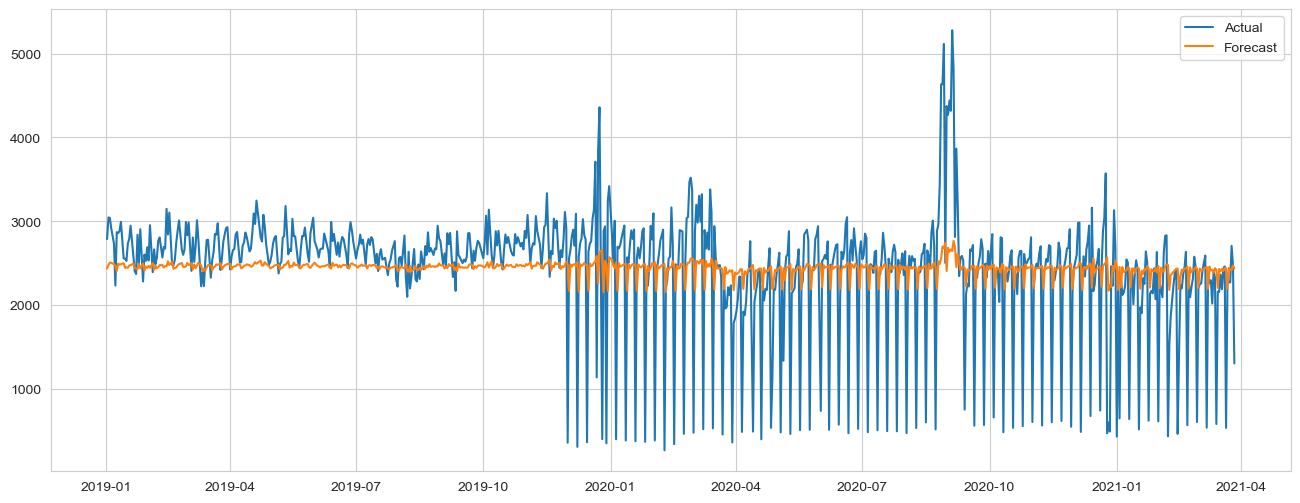

In [55]:
from statsmodels.tsa.arima.model import ARIMA
# Forecast for full time series 
ma_model = ARIMA(store['n_transactions'], order=(0, 0, 1))
ma_model_fit = ma_model.fit()

forecast_ma = ma_model_fit.predict()

# Get the actual sales for the forecast period
actual = store['n_transactions']

mse = mean_squared_error(actual, forecast_ma)
mae = mean_absolute_error(actual, forecast_ma)
mape = mean_absolute_percentage_error(actual, forecast_ma)
rmse = np.sqrt(mse)

print(f'MSE: {mse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.3f}')
print(f'RMSE: {rmse:.3f}')


# plot the forecast vs actual
plt.figure(figsize=(16, 6))
plt.plot(store['n_transactions'], label='Actual')
plt.plot(forecast_ma, label='Forecast')
plt.legend()
plt.show()

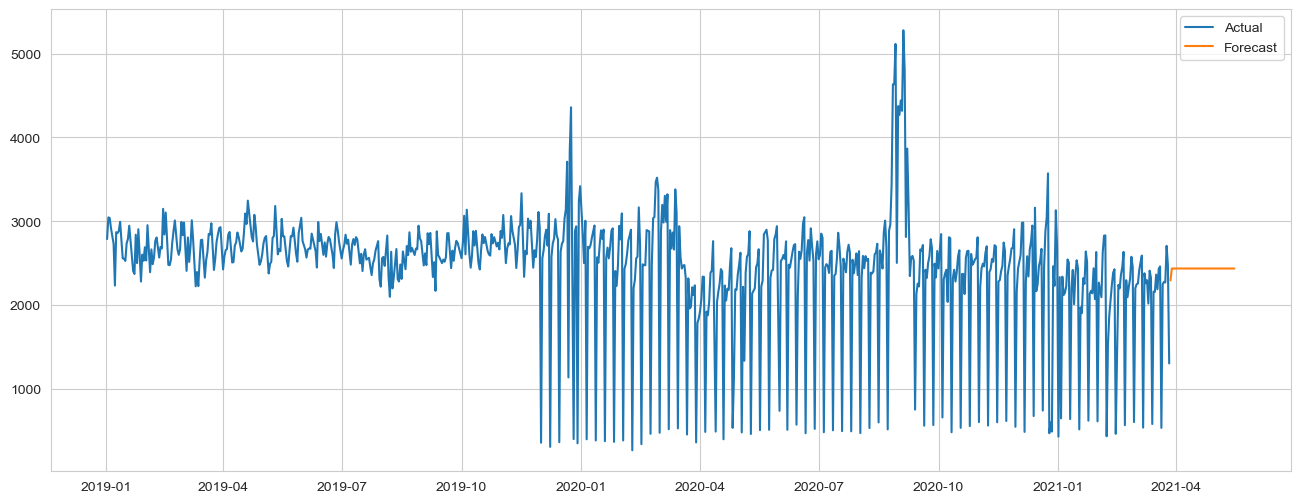

In [56]:
# Forecast for next 50 days with MA model

# create empty future dataframe
future = pd.DataFrame(index=pd.date_range(start='2021-03-28', periods=50, freq='D'), columns=['n_transactions'])
future.sort_index(inplace=True)


# We don't need to fit the model again, we can use the model_fit object we already have
# forecast for the next 50 days of future
forecast_future = ma_model_fit.forecast(steps=50)

# Reset the index of forecast_future
forecast_future.index = future.index

# Fill the future dataframe with the forecast
future['n_transactions'] = forecast_future

# Get the actual sales for the forecast period
actual = store['n_transactions']#.iloc[-50:]

# plot the forecast vs actual
plt.figure(figsize=(16, 6))
plt.plot(store['n_transactions'], label='Actual')
plt.plot(future, label='Forecast')
plt.legend()
plt.show()


# ARIMA model (AutoRegressive Integrated Moving Average)

MSE: 200181.227
MAE: 271.791
MAPE: 0.209
RMSE: 447.416
AIC: 11431.710
BIC: 11510.476


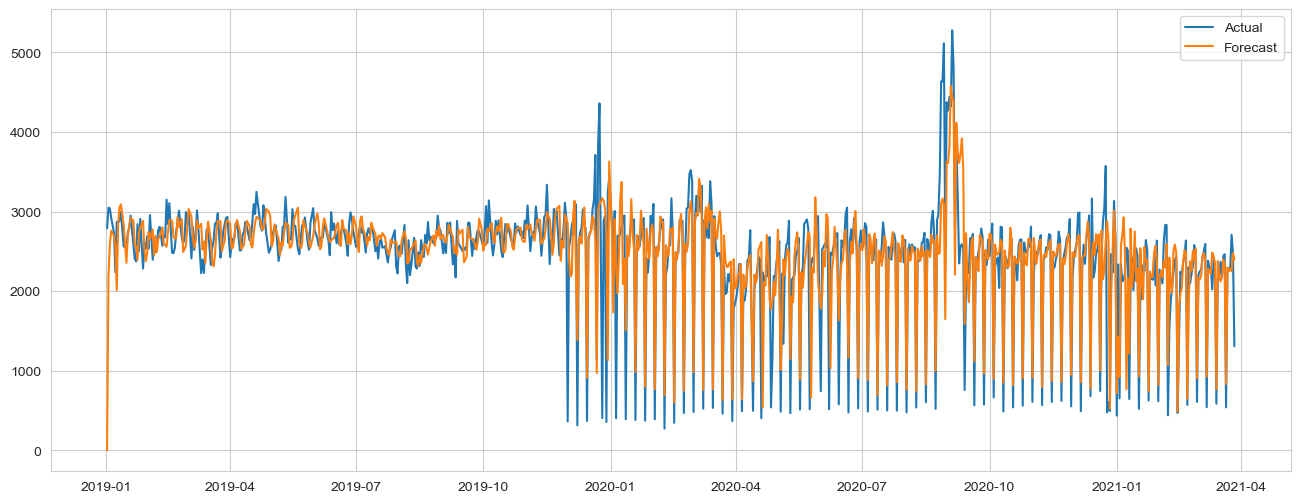

In [57]:
# Predictions for the timeseries with ARIMA model
arima_model = ARIMA(store['n_transactions'], order=(9, 1, 7))

arima_model_fit = arima_model.fit()

forecast_arima = arima_model_fit.predict()

# Get the actual sales for the forecast period
actual = store['n_transactions']

mse = mean_squared_error(actual, forecast_arima)
mae = mean_absolute_error(actual, forecast_arima)
mape = mean_absolute_percentage_error(actual, forecast_arima)
rmse = np.sqrt(mse)

print(f'MSE: {mse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.3f}')
print(f'RMSE: {rmse:.3f}')
# AIC - Akaike Information Criterion
print(f'AIC: {arima_model_fit.aic:.3f}')
# BIC - Bayesian Information Criterion
print(f'BIC: {arima_model_fit.bic:.3f}')

# plot the forecast vs actual
plt.figure(figsize=(16, 6))
plt.plot(store['n_transactions'], label='Actual')
plt.plot(forecast_arima, label='Forecast')
plt.legend()
plt.show()

MSE: 225093.196
MAE: 293.948
MAPE: 0.224
RMSE: 474.440
AIC: 11507.846
BIC: 11549.545


MSE: 200181.227
MAE: 271.791
MAPE: 0.209
RMSE: 447.416
AIC: 11431.710
BIC: 11510.476

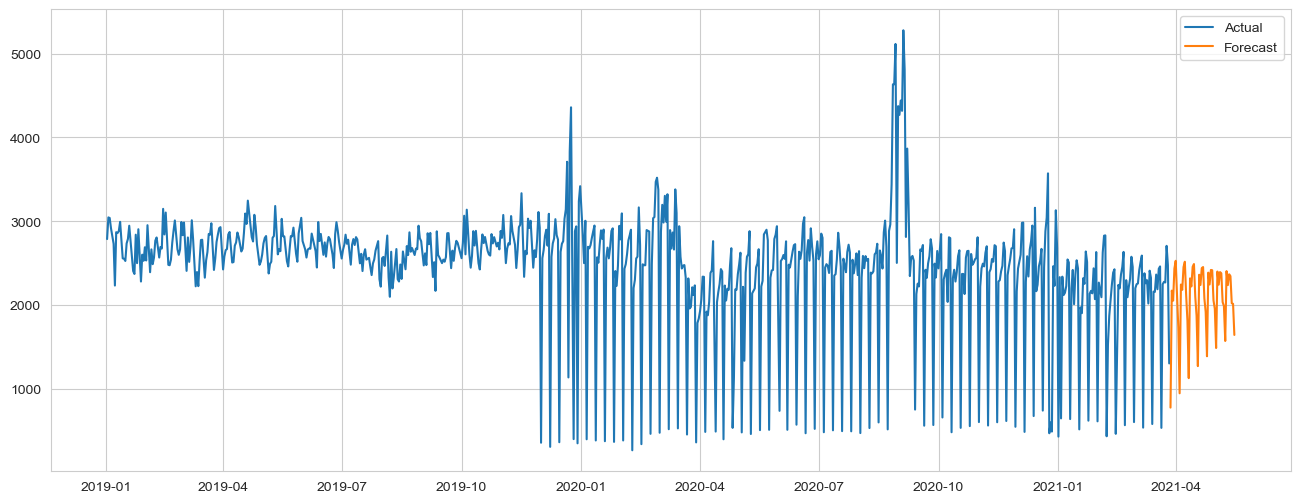

In [58]:
# Forecast for next 50 days

# create empty future dataframe
future = pd.DataFrame(index=pd.date_range(start='2021-03-28', periods=50, freq='D'), columns=['n_transactions'])
future.sort_index(inplace=True)


# forecast for the next 50 days of future
forecast_future = arima_model_fit.forecast(steps=50)

# Reset the index of forecast_future
forecast_future.index = future.index

# Fill the future dataframe with the forecast
future['n_transactions'] = forecast_future

# Get the actual sales for the forecast period
actual = store['n_transactions']#.iloc[-50:]

# plot the forecast vs actual
plt.figure(figsize=(16, 6))
plt.plot(store['n_transactions'], label='Actual')
plt.plot(future, label='Forecast')
plt.legend()
plt.show()


In [59]:
import numpy as np
import warnings
import itertools
warnings.filterwarnings('ignore')

best_aic = np.inf
best_pdq = None

p = q = range(0, 10)
d = [1]

pdq = list(itertools.product(p, d, q))


for param in pdq:
    try:
        model_arima = ARIMA(store['n_transactions'], order=param)
        model_arima_fit = model_arima.fit()
        if model_arima_fit.aic < best_aic:
            best_aic = model_arima_fit.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA parameters: {best_pdq} with AIC: {best_aic}')

Best ARIMA parameters: (9, 1, 7) with AIC: 11431.709521043602


In [61]:
# find best parameters with Autoarima
from pmdarima.arima import auto_arima
    
auto_arima(y=store['n_transactions'],
           seasonal=False, 
        #    m=season_length, #only if seasonal=True
           trace=True #so that you can see what is happening.
)
# It seems that my method is better than auto_arima in this case. The AIC is lower.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12065.858, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12565.774, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12370.612, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12090.766, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12563.778, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12070.634, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12092.937, Time=0.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12049.801, Time=2.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12066.441, Time=1.85 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12021.207, Time=2.06 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=11949.055, Time=1.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12041.472, Time=2.59 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=11772.899, Time=1.25 sec
 ARIMA(5,1,2)(0,0,0)[0] i

ARIMA(order=(5, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [73]:
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.arima.model import ARIMA

def arima_hyperparameters_grid_search(data, diff=0):
    best_aic = np.inf
    best_pdq = None

    # Define the hyperparameters
    hyperparameters = {'p': range(0, 10), 'd': [diff], 'q': range(0, 10)}

    # Create the grid
    grid = ParameterGrid(hyperparameters)

    for params in grid:
        try:
            model_arima = ARIMA(data, order=(params['p'], params['d'], params['q']))
            model_arima_fit = model_arima.fit()
            if model_arima_fit.aic < best_aic:
                best_aic = model_arima_fit.aic
                best_pdq = (params['p'], params['d'], params['q'])
        except Exception as e:
            print(f"Error: {e} with parameters {params}")
            continue
        
    print(f'Best ARIMA parameters: {best_pdq} with AIC: {best_aic}')
    return best_pdq

arima_hyperparameters_grid_search(store['n_transactions'], diff=1)

Best ARIMA parameters: (9, 1, 7) with AIC: 11431.709521043602


(9, 1, 7)

Grid Search for finding the hyperparameters of ARIMA model gives the same result as we found.

# Find the Autocorrelation and Partial Autocorrelation of each store

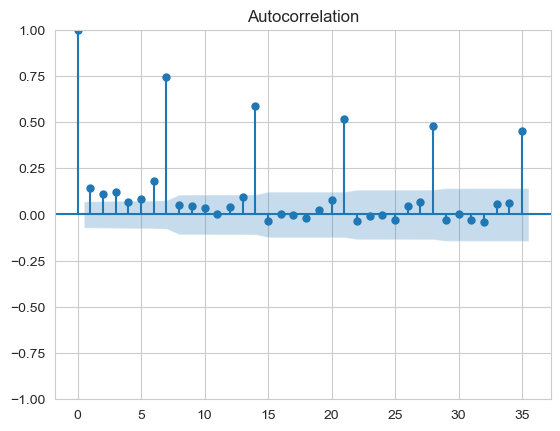

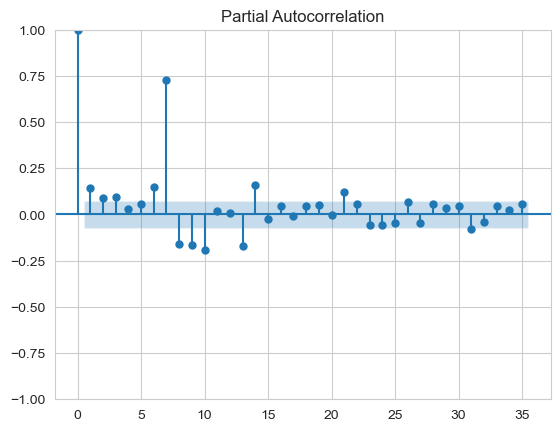

In [68]:
# autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(store['n_transactions'], lags=35)
plot_pacf(store['n_transactions'], lags=35)
plt.show()

# SARIMAX

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29855D+00    |proj g|=  1.83028D+00

At iterate    5    f=  7.55692D+00    |proj g|=  3.99761D-02

At iterate   10    f=  7.55301D+00    |proj g|=  2.86811D-02

At iterate   15    f=  7.55005D+00    |proj g|=  3.30884D-02

At iterate   20    f=  7.54938D+00    |proj g|=  1.02959D-02

At iterate   25    f=  7.54918D+00    |proj g|=  8.77384D-04

At iterate   30    f=  7.54918D+00    |proj g|=  8.10449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

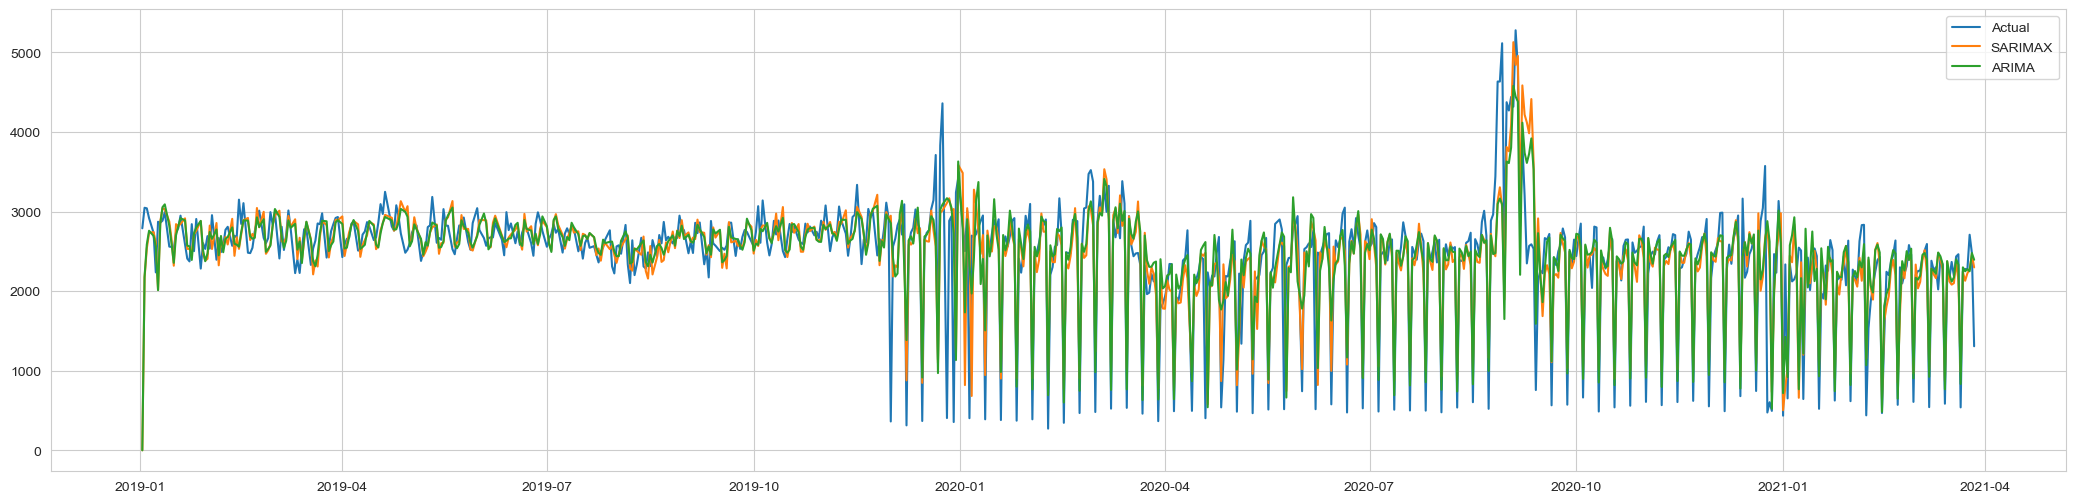

In [70]:
# Forecast for full time series 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = SARIMAX(store['n_transactions'], order=(7, 1, 1), seasonal_order=(0, 0, 0, 7))
model_fit = model.fit()

forecast_sarimax = model_fit.predict()

# Get the actual sales for the forecast period
actual = store['n_transactions']

mse = mean_squared_error(actual, forecast_sarimax)
mae = mean_absolute_error(actual, forecast_sarimax)
mape = mean_absolute_percentage_error(actual, forecast_sarimax)
rmse = np.sqrt(mse)

print(f'MSE: {mse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'MAPE: {mape:.3f}')
print(f'RMSE: {rmse:.3f}')
# AIC - Akaike Information Criterion
print(f'AIC: {model_fit.aic:.3f}')
# BIC - Bayesian Information Criterion
print(f'BIC: {model_fit.bic:.3f}')

# plot the forecast vs actual
plt.figure(figsize=(26, 6))
plt.plot(store['n_transactions'], label='Actual')
plt.plot(forecast_sarimax, label='SARIMAX')
plt.plot(forecast_arima, label='ARIMA')

plt.legend()
plt.show()

In [71]:
# Seasonality is 7 

#  SARIMA model: SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# create empty future dataframe
future = pd.DataFrame(index=pd.date_range(start='2021-03-28', periods=50, freq='D'), columns=['n_transactions'])
future.sort_index(inplace=True)



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29855D+00    |proj g|=  1.83028D+00

At iterate    5    f=  7.55692D+00    |proj g|=  3.99761D-02

At iterate   10    f=  7.55301D+00    |proj g|=  2.86811D-02

At iterate   15    f=  7.55005D+00    |proj g|=  3.30884D-02

At iterate   20    f=  7.54938D+00    |proj g|=  1.02959D-02

At iterate   25    f=  7.54918D+00    |proj g|=  8.77384D-04

At iterate   30    f=  7.54918D+00    |proj g|=  8.10449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

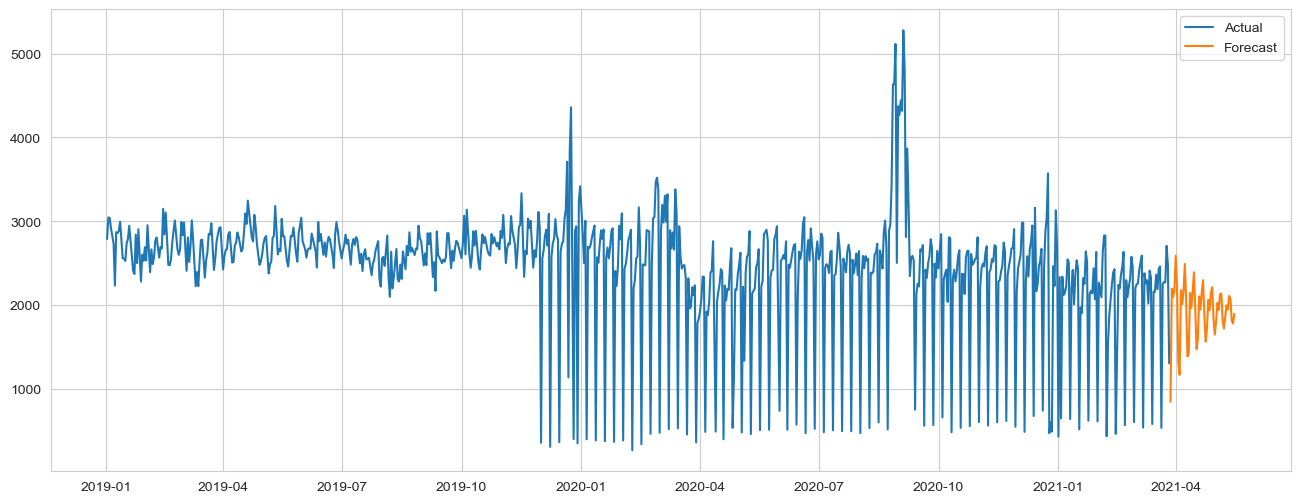

In [72]:
model = SARIMAX(store['n_transactions'], order=(7, 1, 1), seasonal_order=(0, 0, 0, 7))
model_fit = model.fit()

# forecast for the next 50 days of future
forecast_future = model_fit.forecast(steps=50)

# Reset the index of forecast_future
forecast_future.index = future.index

# Fill the future dataframe with the forecast
future['n_transactions'] = forecast_future

# Get the actual sales for the forecast period
actual = store['n_transactions']

# plot the forecast vs actual
plt.figure(figsize=(16, 6))
plt.plot(store['n_transactions'], label='Actual')
plt.plot(future, label='Forecast')
plt.legend()
plt.show()

